In [256]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import random

In [130]:
data = pd.read_csv("12864_2006_660_MOESM1_ESM.csv")

In [131]:
data.describe()

,cDNA_length,cds_length,exons_nr,perc_go_hk_match,perc_go_ts_match
count,35164.000000,35164.000000,20568.000000,25957.000000,25957.000000
mean,2439.950432,1484.058583,6.568748,0.036278,0.222914
std,2012.944961,1502.566846,8.333126,0.131669,0.253348
min,45.000000,45.000000,1.000000,0.000000,0.000000
25%,1168.000000,642.000000,1.000000,0.000000,0.000000
50%,2047.000000,1119.000000,3.000000,0.000000,0.166667
75%,3185.250000,1821.000000,9.000000,0.000000,0.363636
max,99631.000000,98385.000000,118.000000,1.000000,1.000000


In [132]:
data.head()

,EMBL_transcript_id,cDNA_length,cds_length,exons_nr,5_MAR_presence,3_MAR_presence,5_polyA_18_presence,5_CCGNN_2_5_presence,perc_go_hk_match,perc_go_ts_match,is_hk
0,ENST00000274311,2918.0,1158.0,3.0,no,no,no,yes,0.1,0.200000,NaN
1,ENST00000282588,4795.0,3540.0,29.0,no,no,no,yes,0.1,0.200000,NaN
2,ENST00000274311,2918.0,1158.0,3.0,no,no,no,yes,0.1,0.200000,NaN
3,ENST00000282588,4795.0,3540.0,29.0,no,no,no,yes,0.1,0.200000,NaN
4,ENST00000337416,4551.0,1656.0,18.0,no,yes,no,no,0.0,0.111111,NaN


In [133]:
### Cleaning data

data.loc[data["5_MAR_presence"] == "no", "5_MAR_presence"] = 0.0
data.loc[data["5_MAR_presence"] == "yes","5_MAR_presence"] = 1.0
data["5_MAR_presence"] = data["5_MAR_presence"].astype(float)
data.loc[data["3_MAR_presence"] == "no", "3_MAR_presence"] = 0.0
data.loc[data["3_MAR_presence"] == "yes", "3_MAR_presence"] = 1.0
data["3_MAR_presence"] = data["3_MAR_presence"].astype(float)
data.loc[data["5_polyA_18_presence"] == "no", "5_polyA_18_presence"] = 0.0
data.loc[data["5_polyA_18_presence"] == "yes", "5_polyA_18_presence"] = 1.0
data["5_polyA_18_presence"] = data["5_polyA_18_presence"].astype(float)
data.loc[data["5_CCGNN_2_5_presence"] == "no", "5_CCGNN_2_5_presence"] = 0.0
data.loc[data["5_CCGNN_2_5_presence"] == "yes", "5_CCGNN_2_5_presence"] = 1.0
data["5_CCGNN_2_5_presence"] = data["5_CCGNN_2_5_presence"].astype(float)
data.loc[data["is_hk"] == "no", "is_hk"] = 0.0
data.loc[data["is_hk"] == "yes", "is_hk"] = 1.0
del data["EMBL_transcript_id"]

In [134]:
unk_hk = 0
n_hk = 0
n_not_hk = 0
for e in data["is_hk"]:
    if math.isnan(e):
        unk_hk += 1
    elif e == 1.0:
        n_hk += 1
    else:
        n_not_hk += 1

print("unk:{}, hk:{}, not_hk:{}".format(unk_hk, n_hk, n_not_hk))

unk:46459, hk:103, not_hk:667


In [135]:
### Train/Test split
is_train = []
limit_hk = n_hk * 0.9
limit_not_hk = n_not_hk * 0.9

count_hk = 0
count_not_hk = 0


for e in data["is_hk"]:
    if(math.isnan(e)):
        is_train.append(True)
    elif(e == 1):
        if(count_hk < limit_hk):
            count_hk += 1
            is_train.append(True)
        else:
            is_train.append(False)
    else:
        if(count_not_hk < limit_not_hk):
            count_not_hk +=1
            is_train.append(True)
        else:
            is_train.append(False)


is_train = np.array(is_train)

train_set = data[is_train]
test_set = data[~is_train]

unsup_train_set = train_set[train_set["is_hk"].isnull()]
sup_train_set = train_set[~train_set["is_hk"].isnull()]

print(len(train_set),len(unsup_train_set),len(sup_train_set))
print(len(test_set))

47153 46459 694
76


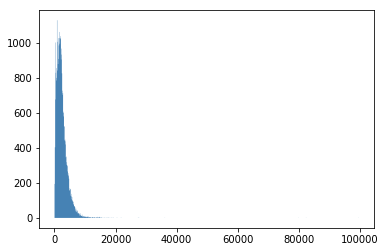

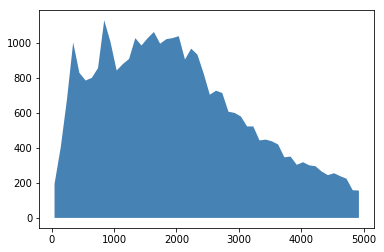

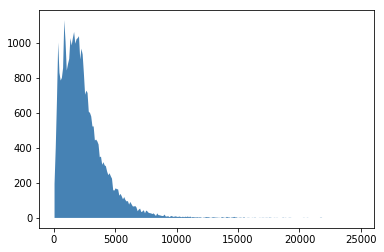

1001 1000


In [136]:
### Histrogram discretization
train_set_clength = train_set["cDNA_length"]
# remove NaN values
train_set_clength_no_nan = train_set_clength[~np.isnan(train_set_clength)]
# bin the data into 1000 equally spaced bins
# hist is the count for each bin
# bin_edge is the edge values of the bins
hist, bin_edge = np.histogram(train_set_clength_no_nan,1000)
# make sure to import matplotlib.pyplot as plt
# plot the histogram
plt.fill_between(bin_edge.repeat(2)[1:-1],hist.repeat(2),facecolor='steelblue')
plt.show()
# plot the first 100 bins only
plt.fill_between(bin_edge.repeat(2)[1:100],hist.repeat(2)[1:100],facecolor='steelblue')
plt.show()
# plot the first 500 bins only
plt.fill_between(bin_edge.repeat(2)[1:500],hist.repeat(2)[1:500],facecolor='steelblue')
plt.show()
print("{} {}".format(len(bin_edge),len(hist)))

In [137]:
zero_count = 0
for e in hist:
    if(e==0):
        zero_count += 1
        
print("zeroes:{}/{}".format(zero_count, len(hist)))

zeroes:823/1000


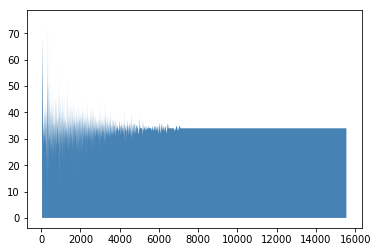

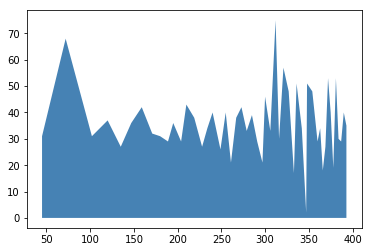

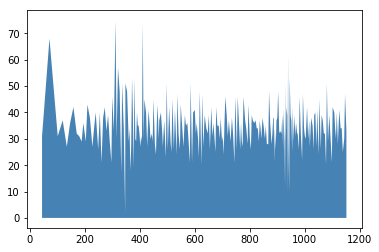

1028


In [398]:
### Histrogram discretization, change bin

train_set_clength_no_nan_sorted = sorted(train_set_clength_no_nan)
# for spacing in range(1,55):
# dna_spacing = 55
dna_spacing = 34
new_bin_edge = np.unique(train_set_clength_no_nan_sorted[0::dna_spacing])
clen_digitize = np.digitize(train_set_clength_no_nan_sorted, new_bin_edge)
bincount = np.bincount(clen_digitize)[1:]
plt.fill_between(new_bin_edge.repeat(2),bincount.repeat(2),facecolor='steelblue')
plt.show()

# plot the first 100 bins only
plt.fill_between(new_bin_edge.repeat(2)[1:100],bincount.repeat(2)[1:100],facecolor='steelblue')
plt.show()

# plot the first 500 bins only
plt.fill_between(new_bin_edge.repeat(2)[1:500],bincount.repeat(2)[1:500],facecolor='steelblue')
plt.show()

print(len(new_bin_edge))

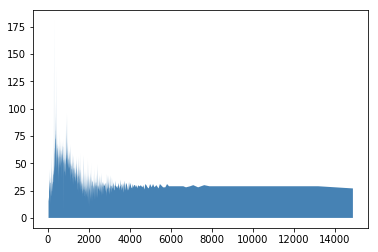

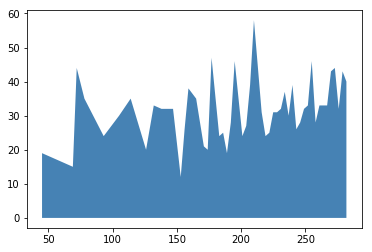

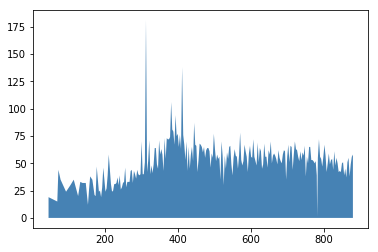

859


In [399]:
### Histrogram discretization, CDS
# cds_spacing = 55
cds_spacing = 29
train_set_cdslength = train_set["cds_length"]
train_set_cdslength_no_nan = train_set_cdslength[~np.isnan(train_set_cdslength)]
train_set_cdslength_no_nan_sorted = sorted(train_set_cdslength_no_nan)
cds_bin_edge = np.unique(train_set_cdslength_no_nan_sorted[0::cds_spacing])
cds_digitize = np.digitize(train_set_cdslength_no_nan_sorted, cds_bin_edge)
cdscount = np.bincount(cds_digitize)[1:]

plt.fill_between(cds_bin_edge.repeat(2),cdscount.repeat(2),facecolor='steelblue')
plt.show()

# plot the first 100 bins only
plt.fill_between(cds_bin_edge.repeat(2)[1:100],cdscount.repeat(2)[1:100],facecolor='steelblue')
plt.show()

# plot the first 500 bins only
plt.fill_between(cds_bin_edge.repeat(2)[1:500],cdscount.repeat(2)[1:500],facecolor='steelblue')
plt.show()
print(len(cds_bin_edge))

In [400]:
### MLE distribution

y_hk = sup_train_set[sup_train_set["is_hk"] == 1]
n_hk = sup_train_set[sup_train_set["is_hk"] == 0]
a_hk = len(y_hk) + len(n_hk)

MLE DISTRIBUTION

[  392.   926.  2622.]
[ 0.3655914  0.3655914  0.2688172]


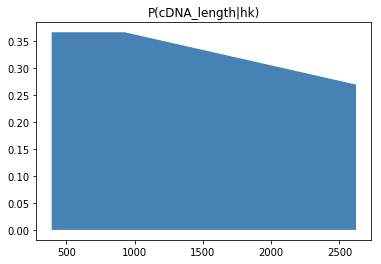

[  135.   510.   960.  2256.]
[ 0.31182796  0.31182796  0.31182796  0.06451613]


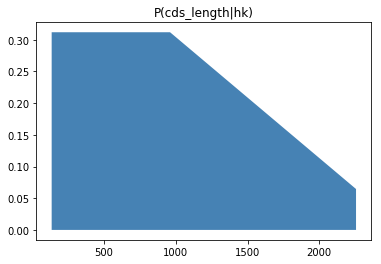

[  2.   4.   5.   6.   8.   9.  10.  13.  15.]
[ 0.04761905  0.19047619  0.23809524  0.14285714  0.04761905  0.0952381
  0.0952381   0.04761905  0.0952381 ]


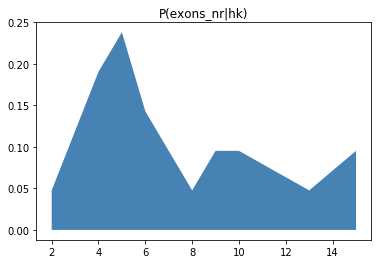

[ 0.  1.]
[ 0.95698925  0.04301075]


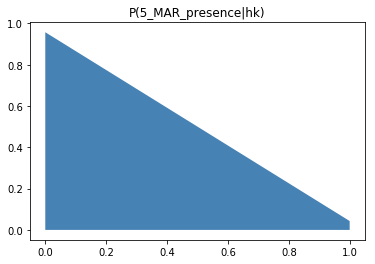

[ 0.  1.]
[ 0.92473118  0.07526882]


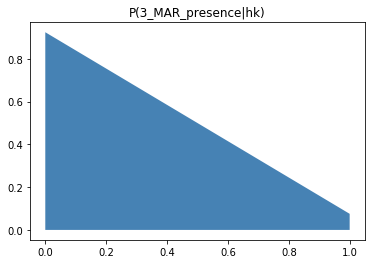

[ 0.  1.]
[ 0.83870968  0.16129032]


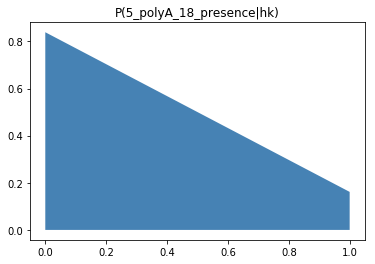

[ 0.  1.]
[ 0.51612903  0.48387097]


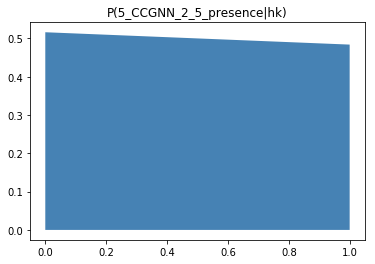

[ 0.         0.1111111  0.1666667  0.1818182  0.2        0.25       0.2857143
  0.3333333  0.3571429  0.4        0.4285714  0.4444444  0.4615385  0.5
  0.5555556  0.6        0.6666667  0.7142857  0.75       0.8        0.8333333
  1.       ]
[ 0.15217391  0.02173913  0.05434783  0.0326087   0.04347826  0.04347826
  0.02173913  0.14130435  0.02173913  0.01086957  0.02173913  0.01086957
  0.02173913  0.04347826  0.0326087   0.04347826  0.06521739  0.0326087
  0.02173913  0.07608696  0.01086957  0.07608696]


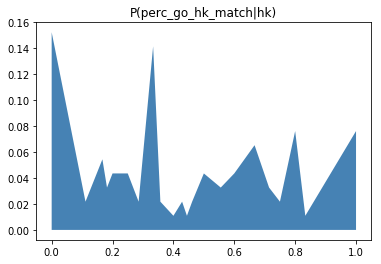

[ 0.]
[ 1.]


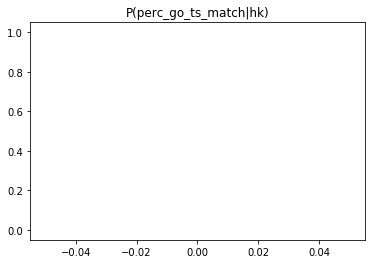

In [401]:
### MLE distribution
print("MLE DISTRIBUTION\n")
keys = ("cDNA_length","cds_length","exons_nr")
spacing = (dna_spacing,cds_spacing,1,1,1,1,1,1,1,1)
spacing_i = 0
MLE = []

for e in y_hk:
    if(e != "is_hk"):
        d = y_hk[e]        
        d = d[~np.isnan(d)]
        y_hk_sorted = sorted(d)
        y_x_bins = np.unique(y_hk_sorted[0::spacing[spacing_i]])
        spacing_i += 1
        y_x_digitize = np.digitize(y_hk_sorted, y_x_bins)
        y_x_count = np.bincount(y_x_digitize)[1:]/len(d)
        print(y_x_bins)
        print(y_x_count)
        MLE.append((y_x_bins, y_x_count))
        plt.title("P({}|hk)".format(e))
        plt.fill_between(y_x_bins.repeat(2),y_x_count.repeat(2),facecolor='steelblue')
        plt.show()

In [402]:
### Prior distribution
P_Y = len(y_hk) / a_hk
P_N = len(n_hk) / a_hk

print("Prior distribution\n")
print("P(hk) = {}\nP(not hk) = {}".format(P_Y,P_N))

Prior distribution

P(hk) = 0.1340057636887608
P(not hk) = 0.8659942363112392


In [403]:
def H(x):
    lprob_yes = 0
    lprob_no = 0
    for i in range(len(x)):        
        if(math.isnan(x[i])):
            continue
        for j in range(len(MLE[i][0])-1):            
            if(MLE[i][0][j] <= x[i] < MLE[i][0][j+1]):
                lprob_yes += math.log(MLE[i][1][j])
                lprob_no += math.log(1 - MLE[i][1][j])
            elif(x[i] >= MLE[i][0][-1]):
                lprob_yes += math.log(MLE[i][1][-1])
                lprob_no += math.log(1 - MLE[i][1][-1])
            else:
                break
    
    return math.log(P_Y) - math.log(P_N) + lprob_yes - lprob_no

In [404]:
def predict(X,threshold = 0):
    pred = []
    mat_X = X.as_matrix()
    for data in mat_X:
        if(H(data) >= threshold):
            pred.append(1.)
        else:
            pred.append(0.)
    return pred

In [405]:
def eval(pred,y):
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    for i in range(len(pred)):
        if(y[i] == 1):
            if(pred[i] == 1):
                true_pos += 1
            else:
                false_neg += 1
        else:
            if(pred[i] == 0):
                true_neg += 1
            else:
                false_pos += 1

    # print(true_pos, true_neg, false_pos, false_neg)            

    accuracy = (true_pos+true_neg)/(true_pos + true_neg + false_pos + false_neg)
    if(true_pos+false_pos == 0 ):
        precision = math.nan
    else:
        precision = true_pos/(true_pos + false_pos)
    if(true_pos+false_neg == 0):
        recall = math.nan
    else:
        recall = true_pos/(true_pos + false_neg)
    F_score = 2 * precision * recall / (precision+recall)
    return accuracy, precision, recall, F_score

In [406]:
### Test evaluation

X_test = test_set.copy()
y_test = test_set["is_hk"].as_matrix()
# X_test = y_hk.copy()
# y_test = y_hk["is_hk"].as_matrix()

del X_test["is_hk"]
pred = predict(X_test)
print("---NAIVE BAYES---")
accuracy,precision,recall,F_score = eval(pred,y_test)
print("accuracy: {}\nprecision: {}\nrecall: {}\nF score: {}".format(accuracy,precision,recall,F_score))

---NAIVE BAYES---
accuracy: 0.4473684210526316
precision: 0.16666666666666666
recall: 0.8
F score: 0.27586206896551724


In [407]:
### random guess
X_test = test_set.copy()
y_test = test_set["is_hk"].as_matrix()
pred = []
for i in range(len(X_test)):
    if(random.random() >= 0.5):
        pred.append(1.)
    else:
        pred.append(0.)
print("---RANDOM GUESS---")
accuracy,precision,recall,F_score = eval(pred,y_test)
print("accuracy: {}\nprecision: {}\nrecall: {}\nF score: {}".format(accuracy,precision,recall,F_score))

---RANDOM GUESS---
accuracy: 0.4605263157894737
precision: 0.12195121951219512
recall: 0.5
F score: 0.19607843137254902


In [408]:
### majority rule
y  = sup_train_set["is_hk"].as_matrix()
y_test = test_set["is_hk"].as_matrix()

pos = sum(y)
pred = []
if(pos > len(y)//2):
    pred = [1]*len(y_test)
else:
    pred = [0]*len(y_test)

print("---MAJORITY---")

accuracy,precision,recall,F_score = eval(pred,y_test)
print("accuracy: {}\nprecision: {}\nrecall: {}\nF score: {}".format(accuracy,precision,recall,F_score))

---MAJORITY---
accuracy: 0.868421052631579
precision: nan
recall: 0.0
F score: nan


In [409]:
### Threshold
X_test = test_set.copy()
y_test = test_set["is_hk"].as_matrix()
del X_test["is_hk"]
pred = predict(X_test)

best_t_acc = 0
best_acc = 0
best_t_f = 0
best_f = 0

for t in np.arange(-5,5,0.05):
    pred = predict(X_test,t)
    acc,pre,rec,f = eval(pred,y_test)
    if(acc > best_acc):
        best_t_acc = t
        best_acc = acc
    if(f > best_f):
        best_t_f = t
        best_f = f

print("best acc: {} threshold: {}".format(best_acc,best_t_acc))
print("best f score: {} threshold: {}".format(best_f,best_t_f))

best acc: 0.9210526315789473 threshold: 3.749999999999968
best f score: 0.5714285714285715 threshold: 3.749999999999968


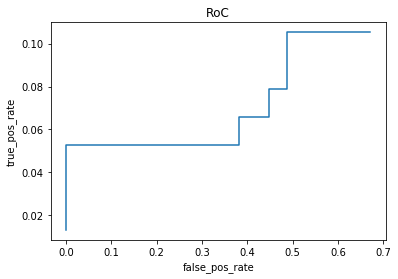

200


In [410]:
### RoC

X_test = test_set.copy()
y_test = test_set["is_hk"].as_matrix()
del X_test["is_hk"]

true_pos_rate = []
false_pos_rate = []
ts = np.arange(-5,5,0.05)
for t in ts:
    pred = predict(X_test,t)    
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    for i in range(len(pred)):
        if(y_test[i] == 1):
            if(pred[i] == 1):
                true_pos += 1
            else:
                false_neg += 1
        else:
            if(pred[i] == 0):
                true_neg += 1
            else:
                false_pos += 1
        
    overall = (true_pos + true_neg + false_pos + false_neg)
    true_pos_rate.append(true_pos/overall)
    false_pos_rate.append(false_pos/overall)
        
plt.title("RoC")
plt.xlabel("false_pos_rate")
plt.ylabel("true_pos_rate")
plt.plot(false_pos_rate,true_pos_rate)
plt.show()
print(len(false_pos_rate))